参考: https://qiita.com/sugulu_Ogawa_ISID/items/697bd03499c1de9cf082

In [36]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader

print(torch.__version__)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

1.11.0+cu113


device(type='cuda')

In [3]:
train_df = pd.read_csv("train_eval.tsv", sep="\t",  names=('text', 'label'))
test_df = pd.read_csv("test.tsv", sep="\t",  names=('text', 'label'))

test_df.head

<bound method NDFrame.head of                                                    text  label
0     Peachyでも大人気の「恋愛」をテーマにした記事の週間ランキングです！2012年6月21日...      5
1     値下げや利用可能国が拡大！テレコムスクエアは1日、ポストペイドタイプの海外向けSIMカード「...      6
2     ４月。新しい年度を迎え、新しい顧客の開拓、新しい取引先、新しい上司や同僚。エネルギーに満ち溢...      3
3     Xperia GXが発表！ソニーモバイルコミュニケーションズは9日、国内向けとして2012年...      6
4     1月も後半に入り、バレンタインデーの話題も増えてきた今日この頃。皆さんはチョコを贈る相手、決...      5
...                                                 ...    ...
1470  今週末26日、さいたまスーパーアリーナで開催される世界最高峰の総合格闘技イベント＝UFC日本...      7
1471  名番組「突撃！隣の晩ごはん」のヨネスケが、今度は「OLの昼ごはん」をレポートする。華やかな企...      0
1472  新年度を迎え、周りの環境も変わると、職場や取引先でも新しい出会いが増えるこの季節。名刺交換中...      5
1473  5日深夜、アルガルベカップで、宿敵アメリカ代表からはじめて勝利を挙げたサッカー女子日本代表＝...      7
1474  「男子厨房に入らず」—。「弁当男子」なんて言葉も登場している現代では、死語と言えるだろう。で...      0

[1475 rows x 2 columns]>

In [4]:
# データのカウント
label_list = train_df["label"].unique()
train_df["label"].value_counts() + test_df["label"].value_counts()


0    871
1    871
2    865
3    512
4    871
5    843
6    871
7    901
8    771
Name: label, dtype: int64

In [5]:
train_df, valid_df = train_test_split(train_df, test_size=0.2, shuffle=False)

In [6]:
import torch
from transformers import AdamW, AutoTokenizer, AutoModelForMaskedLM, AutoModelForSequenceClassification
model_path = "cl-tohoku/bert-base-japanese"
# model_path = "izumi-lab/electra-base-japanese-discriminator"
# model_path = "izumi-lab/electra-small-japanese-fin-discriminator"


In [7]:
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=len(label_list))
model

Some weights of the model checkpoint at cl-tohoku/bert-base-japanese were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [80]:
max_len = 100
train_encoding = tokenizer(train_df["text"].to_list(), return_tensors="pt",padding=True, truncation=True, max_length=max_len)
valid_encoding = tokenizer(valid_df["text"].to_list(), return_tensors="pt",padding=True, truncation=True, max_length=max_len)
test_encoding = tokenizer(test_df["text"].to_list(), return_tensors="pt",padding=True, truncation=True, max_length=max_len)

In [30]:
train_label = torch.tensor(train_df["label"].to_list())
valid_label = torch.tensor(valid_df["label"].to_list())
test_label = torch.tensor(test_df["label"].to_list())

In [31]:
# 0 番目 の 5 トーク ン までの ID を 表示
print(train_encoding["input_ids"][ 0][: 5]) 
# 0 番目 の 5 トーク ン までの トー クン を デコード し て 表示
print(tokenizer.decode(train_encoding["input_ids"][0][:5]))

tensor([    2, 20587,   104,   737,  3654])
[CLS] 転職 者 なら 誰


In [41]:
class CreateDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    
    def __getitem__( self, idx):
        item = {key:torch.tensor(val[idx]).clone().detach() for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx]).clone().detach()
        return item
    
    def __len__( self):
        return len(self.labels)

train_dataset = CreateDataset(train_encoding, train_label)
val_dataset = CreateDataset(valid_encoding, valid_label)
test_dataset = CreateDataset(test_encoding, test_label)


In [42]:
for i in train_dataset:
    print(i.keys())
    print(i)
    break

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'labels'])
{'input_ids': tensor([    2, 20587,   104,   737,  3654,   962,   704,     7,   139,  1062,
           34,   563,     5,  4888,     8,   373,     6,  1379,     7,  7849,
          919,   104,    40,   108, 28833,    11,  6296, 26634,    45,     9,
        10289,   203,    80,   120,     8,  2909,    70,  3001,    12,     9,
            6,   378,     5,  7290,   104,    11,   212,    16,   322,     3]), 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1]), 'labels': tensor(3)}


C:\Users\windo\AppData\Local\Temp\ipykernel_28740\1214768838.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key:torch.tensor(val[idx]).clone().detach() for key, val in self.encodings.items()}
C:\Users\windo\AppData\Local\Temp\ipykernel_28740\1214768838.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx]).clone().detach()


In [43]:
def saveModel(): 
    path = "./PreBertModel.pth" 
    torch.save(model.state_dict(), path)

model = model.to(device)

In [95]:
loss_fn = torch.nn.CrossEntropyLoss()
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
validate_loader = DataLoader(val_dataset, batch_size = 32, shuffle = True)

optimizer = AdamW(model.parameters(), lr=5e-4)
model.train()
epochs = 5
train_losses = []
valid_losses = []
acc_epoc = []
best_accuracy = 0.0 

model.train()
#再学習
for epoch in range(epochs):
    print(f"epoch num: {epoch}")
    running_train_loss = 0.0 
    running_accuracy = 0.0 
    running_vall_loss = 0.0 
    total = 0 

    # Training Loop 
    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask = attention_mask, labels = labels)
        logits = outputs.logits
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        train_losses.append(loss)
        running_train_loss +=loss.item()

    # Calculate training loss value 
    train_loss_value = running_train_loss/len(train_loader) 
    
    # Validation Loop 
    with torch.no_grad(): 
        model.eval() 
        for batch in tqdm(validate_loader): 
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask = attention_mask, labels = labels)
            logits = outputs.logits
            val_loss = outputs.loss
            valid_losses.append(val_loss)
            
            # The label with the highest value will be our prediction 
            _, predicted = torch.max(logits, 1) 
            running_vall_loss += val_loss.item()  
            total += logits.size(0) 
            running_accuracy += (predicted == labels).sum().item()

    # Calculate validation loss value 
    val_loss_value = running_vall_loss/len(validate_loader) 
            
    # Calculate accuracy as the number of correct predictions in the validation batch divided by the total number of predictions done.  
    accuracy = (100 * running_accuracy / total)
    acc_epoc.append(accuracy)    

    # Save the model if the accuracy is the best 
    if accuracy > best_accuracy: 
        saveModel() 
        best_accuracy = accuracy


    print(f"epoch:{epoch+1}, train loss:{train_loss_value}, validate loss:{running_vall_loss}")
    print('Completed training batch', epoch, 'Training Loss is: %.4f' %train_loss_value, 'Validation Loss is: %.4f' %val_loss_value, 'Accuracy is %d %%' % (accuracy))

epoch num: 0


  0%|          | 0/148 [00:00<?, ?it/s]C:\Users\windo\AppData\Local\Temp\ipykernel_28740\1214768838.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key:torch.tensor(val[idx]).clone().detach() for key, val in self.encodings.items()}
C:\Users\windo\AppData\Local\Temp\ipykernel_28740\1214768838.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx]).clone().detach()
100%|██████████| 37/37 [00:03<00:00, 10.34it/s]


epoch:1, train loss:2.243993445022686, validate loss:81.91699147224426
Completed training batch 0 Training Loss is: 2.2440 Validation Loss is: 2.2140 Accuracy is 11 %
epoch num: 1


 11%|█▏        | 17/148 [00:05<00:42,  3.05it/s]


KeyboardInterrupt: 

In [93]:
_, predicted = torch.max(logits, 1) 
running_vall_loss += val_loss.item()  
total += logits.size(0) 
running_accuracy += (predicted == labels).sum().item()

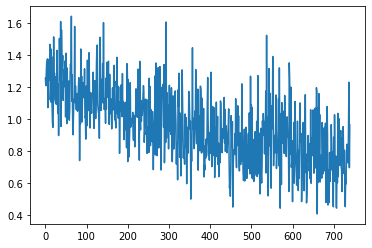

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
losses_ = [loss.to('cpu').detach().numpy() for loss in losses]
plt.plot(losses_)
plt.show()

In [74]:
model.eval()
preds = []
test_label = test_df["label"].to_list()
with torch.no_grad():
    for words in tqdm(test_df["text"].to_list()):
        text = "".join(words)
        inputs = tokenizer.encode(text, return_tensors="pt",padding=True, truncation=True, max_length=max_len).to(device)
        outputs = model(inputs)
        logits = outputs.logits
        pred=logits.argmax(1).item()
        preds.append(pred)

100%|██████████| 1475/1475 [00:21<00:00, 67.17it/s]


In [75]:
correct_cnt = 0
for pred, ans in zip(preds, test_label):
    if pred == ans:
        correct_cnt += 1 # 正解 率（ ＝ 全 データ の うち 正解 が どれ だけか)
print( correct_cnt/ len(test_label))

0.6501694915254237


カテゴリー数: 9
['dokujo-tsushin', 'it-life-hack', 'kaden-channel', 'livedoor-homme', 'movie-enter', 'peachy', 'smax', 'sports-watch', 'topic-news']


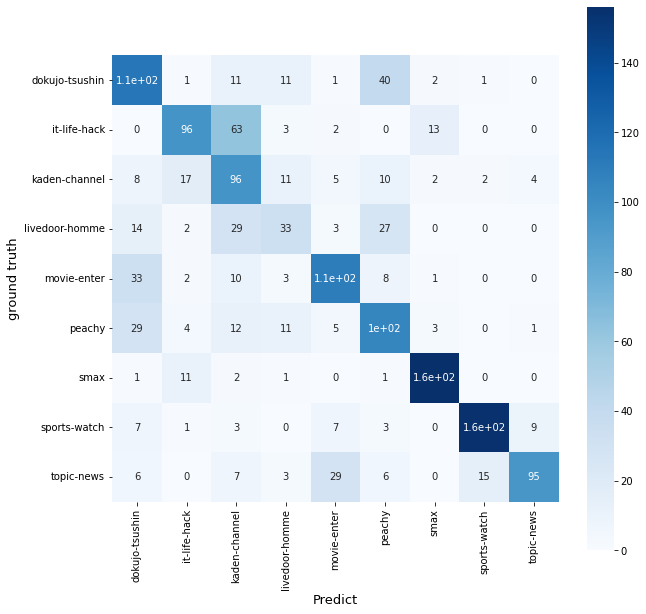

In [77]:
from sklearn.metrics import confusion_matrix

categories = [name for name in os.listdir(
    "./data/livedoor/text/") if os.path.isdir("./data/livedoor/text/"+name)]

print("カテゴリー数:", len(categories))
print(categories)

cm = confusion_matrix(test_label, preds)
cm = pd.DataFrame(data=cm, index=categories, 
                           columns=categories,)

fig = plt.figure()
sns.heatmap(cm, square=True, cbar=True, annot=True, cmap='Blues')
plt.yticks(rotation=0)
plt.xlabel("Predict", fontsize=13, rotation=0)
plt.ylabel("ground truth", fontsize=13)
fig.set_figheight(10)
fig.set_figwidth(10)